# Regridding

PyLag includes functionality that makes it possible to interpolate input data to particle positions. With v0.6, basic support for utilising this functionality to regrid model outputs has been included via the subpackage `pylag.regrid`. We demonstrate this facility here using FVCOM model outputs for the Tamar Estuary. More details on the FVCOM domain can be found in the [FVCOM Forward Tracking tutorial](../../examples/fvcom_forward_tracking.ipynb).

## The input grid

PyLag reads information about the input grid from a grid metrics file, which must be created first. As in the FVCOM Forward Tracking tutorial, we need two types of file to create a FVCOM grid metrics file: 1) an example FVCOM output file, and 2) the file that lists the location of the domain’s open boundary nodes. With these two files in place, we can create the grid metrics file in the same way we did in the FVCOM Forward Tracking Tutorial. Here, we save the file into a new directory called `regridding`.

In [1]:
import os
import pathlib

from pylag.grid_metrics import create_fvcom_grid_metrics_file

# Root directory for PyLag example input files
home_dir = os.environ['HOME']
data_dir=f'{home_dir}/data/pylag_doc'

# An example FVCOM output file
fvcom_file_name = f'{data_dir}/fvcom_tamar_estuary_0001.nc'

# The file listing the location of open boundary nodes
obc_file_name = f'{data_dir}/fvcom_tamar_estuary_obc.dat'

# Name and create the directory in which the grid metrics file will be saved
regridding_dir = f'./regridding'
pathlib.Path(regridding_dir).mkdir(parents=True, exist_ok=True)

# The name of the output file
grid_metrics_file_name = f'{regridding_dir}/grid_metrics.nc'

# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file ./regridding/grid_metrics.nc
Grid has 45 nodes on the open boundary


## Creating the new grid

Next we import all required modules, including plotting libraries, and define a helper function for creating new lat-lon grids.

In [2]:
# Required imports
from collections import namedtuple
import numpy as np
import datetime
from netCDF4 import Dataset
import configparser
from matplotlib import pyplot as plt
from cftime import num2pydate
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands


# Named tuple for the grid limits
GridLims = namedtuple('GridLims', ('lon_min', 'lon_max', 'lat_min', 'lat_max'))


def get_lons_lats(grid_lims, points_per_degree):
    """ Helper function for generating lat and lon grids
    
    Parameters
    ----------
    grid_lims : GridLims
        Named tuple giving the grid limits.
    
    points_per_degree : int
        The number of points per degree longitude and latitude.
    
    Returns
    -------
    lon, lat : NDArray
        1D lon and lat arrays for the new grid.
    """
    # Generate lat and lon grids 
    n_lon = int((grid_lims.lon_max - grid_lims.lon_min) * points_per_degree)
    n_lat = int((grid_lims.lat_max - grid_lims.lat_min) * points_per_degree)
    lon = np.linspace(grid_lims.lon_min, grid_lims.lon_max, n_lon, dtype=float)
    lat = np.linspace(grid_lims.lat_min, grid_lims.lat_max, n_lat, dtype=float)

    return lon, lat

Next, we define the grid that we want to interpolate FVCOM data onto. We base this on the latitude and longitude limits of the original grid, and define a set number of points per degree longtitude and latitude (72 in this case). Here, we only want surface data, so we create a depth array that is equal to zero throughout.

In [3]:
# Set date limits for interpolating data. PyLag will use this
# to confirm that data is available between these time points.
datetime_start = datetime.datetime(2020,5,2,3)
datetime_end = datetime.datetime(2020,5,2,18)

# Generate the new grid on which to interpolate data
# --------------------------------------------------

# Use lon and lat lims for the (unstructured) input grid for the new grid
ds = Dataset(grid_metrics_file_name, 'r')
grid_lims = GridLims(ds['longitude_c'][:].min(),
                     ds['longitude_c'][:].max(),
                     ds['latitude_c'][:].min(),
                     ds['latitude_c'][:].max())
ds.close()
del(ds)

# The number of points per degree on the new grid
points_per_degree = 72

# Generate the grid
lon, lat = get_lons_lats(grid_lims, points_per_degree)

# Save grid shape
n_lon = lon.shape[0]
n_lat = lat.shape[0]

# Save grid bands for plotting
lon_edges = get_grid_bands(lon)
lat_edges = get_grid_bands(lat)

# Lon and lat grids (2D)
lat2D, lon2D = np.meshgrid(lat, lon, indexing='ij')
lon2D_flat = lon2D.flatten()
lat2D_flat = lat2D.flatten()

# The total number of grid points
n_points = lon2D_flat.shape[0]

# Depth grid (surface only)
depth = np.array([0.0], dtype=float)
depth_flat = np.ones(n_points, dtype=float) * depth[0]

# Save grid shape
n_depth = depth.shape[0]

## Regridding the data

Next we create a small config, which PyLag will use to work out where the data is and some details about its format. Following this, we instantiate the regridder. During this process, PyLag computes a set of interpolation weights, which can take some time. However, this is a one-off process.

In [4]:
# Create config
config = configparser.ConfigParser()
config.add_section('SIMULATION')
config.set('SIMULATION', 'coordinate_system', 'geographic')
config.add_section('OCEAN_DATA')
config.set('OCEAN_DATA', 'name', 'FVCOM')
config.set('OCEAN_DATA', 'data_dir', f'{data_dir}')
config.set('OCEAN_DATA', 'grid_metrics_file', f'{grid_metrics_file_name}')
config.set('OCEAN_DATA', 'data_file_stem', 'fvcom_tamar_estuary_0')
config.set('OCEAN_DATA', 'rounding_interval', '3600')
config.set('OCEAN_DATA', 'Kz_method', 'none')
config.set('OCEAN_DATA', 'Ah_method', 'none')
config.set('OCEAN_DATA', 'has_is_wet', 'True')

# Explicitly list the environmental variables we are interested in. This
# ensures the required ariables are read into memory.
config.add_section('OUTPUT')
config.set('OUTPUT', 'environmental_variables', 'thetao, so')

# Extra options to help the config pass PyLag's internal checks
config.add_section('NUMERICS')
config.set('NUMERICS', 'num_method', 'test')
config.set('NUMERICS', 'time_step_adv', '1')

# Create the regridder. 
r = regridder.Regridder(config, lon2D_flat, lat2D_flat, depth_flat, datetime_start, datetime_end)

Computing weights ... done!


We now need to define the variables we would like to regrid. The regridder accepts a list of variables for regridding, making it possible to regrid more than one variable at a time. Here, we generate regridded data for the lateral velocity components, salinity and sea water potential temperature. We must also state the date and time we would like to interpolate data to. As long as this is covered by the input data, PyLag will interpolate the data to the correct time point. Note it is only possible to pass in a single time point per call. The data can be interpolated to multiple time points through multiple calls.

The interpolated data is returned in the form of 1D arrays stored in a dictionary. These 1D arrays can be reshaped, giving the data on the original 3D grid.

In [5]:
# The names of the variables we want interpolated data for
var_names = ['uo', 'vo', 'so', 'thetao']

# Time at which we want the interpolated data
datetime_now = datetime.datetime(2020,5,2,12)

# Get interpolated data
data = r.interpolate(datetime_now, var_names)

# Reshape 1D arrays
for var_name in var_names:
    data[var_name] = data[var_name].reshape(n_depth, n_lat, n_lon).astype(float)

## Plotting the result

To demonstrate the regidder is working, we plot the surface temperature field at the given time point. We do this twice: once for the original FVCOM temperature data, and once for the regridded data. First, we define some useful variables to assist with plotting.

In [6]:
# Variable name
temp_var_name = 'thetao'

# FVCOM var name(s)
fvcom_var_name = {temp_var_name: 'temp'}

# Limits
vmin = {temp_var_name: 10}
vmax = {temp_var_name: 14}

### FVCOM surface temperature

To plot the FVCOM surface temperature field, we first extract data at the corrsponding time point, then plot it.

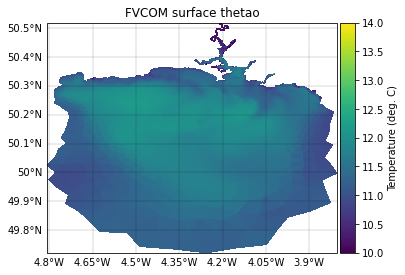

In [6]:
# Read in the original FVCOM data at the correct time index
fvcom_viewer = Viewer(fvcom_file_name)
time_raw = fvcom_viewer('Itime')[:] + fvcom_viewer('Itime2')[:] / 1000. / 60. / 60. / 24.
units = fvcom_viewer('Itime').units
fvcom_datetime = num2pydate(time_raw[:], units=units)
fvcom_tidx = fvcom_datetime.tolist().index(datetime_now)
fvcom_surface_var = fvcom_viewer(fvcom_var_name[temp_var_name])[fvcom_tidx, 0, :]

# Plot surface temperature data on the original FVCOM grid
plotter = FVCOMPlotter(grid_metrics_file_name)
fig, ax = create_figure(figure_size=(14,14), projection=ccrs.PlateCarree())
plot = plotter.plot_field(ax, fvcom_surface_var, vmin=vmin[temp_var_name], vmax=vmax[temp_var_name],
                          cb_label='Temperature (deg. C)')
title = ax.set_title(f'FVCOM surface {temp_var_name}', fontsize=10)

### Regridded surface temperature field

We plot the regridded field directly, using data from the dictionary.

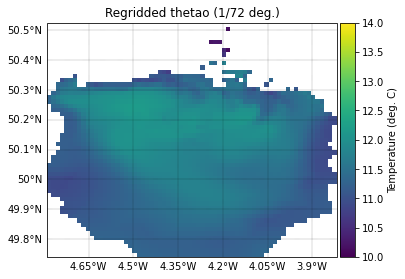

In [7]:
# Create the figure
fig, ax = create_figure(figure_size=(14,14), projection=ccrs.PlateCarree())

# Plot temperature
plot = ax.pcolormesh(lon_edges, lat_edges, data[temp_var_name][0, :],
                     vmin=vmin[temp_var_name], vmax=vmax[temp_var_name],
                     transform=ccrs.PlateCarree())
_ = ax.set_title(f'Regridded {temp_var_name} (1/{points_per_degree} deg.)', fontsize=10)

# Add colour bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(plot, cax=cax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Temperature (deg. C)', fontsize=10)

extents = np.array([lon_edges.min(), lon_edges.max(), lat_edges.min(), lat_edges.max()])
ax.set_extent(extents)

gl = ax.gridlines(linewidth=0.2, draw_labels=True, linestyle='--', color='k')

gl.xlabel_style = {'fontsize': 10}
gl.ylabel_style = {'fontsize': 10}

gl.top_labels=False
gl.right_labels=False
gl.bottom_labels=True
gl.left_labels=True

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

_ = ax.set_xlabel('Longitude (E)', fontsize=10)
_ = ax.set_ylabel('Longitude (N)', fontsize=10)

In qualitative terms, it can be seen the two are a close match. Note that PyLag returns masked data for all points that lie outside of the domain. It is evident the Tamar Estuary is poorly resolved, but this is to be expected - we have regridded the data onto a relatively coarse regular grid.